Load Training Set: MINSTOrigin, MINSTModified

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = "/kaggle/input/mnist-upscayled/TrainingData"
image_size = (28, 28) 
batch_size = 100 

datagen = ImageDataGenerator(
    rescale=1.0 / 255,  
    rotation_range= 80,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.2,1.0],
    validation_split=0.2
)

datagen_O = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2
) #Original


train_generator_A = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="training"
)

val_generator_A = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="validation"
)

train_generator_O = datagen_O.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="training"
)

val_generator_O = datagen_O.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="validation"
)

#print("Class label mapping：", train_generator.class_indices)

Found 67200 images belonging to 2 classes.
Found 16800 images belonging to 2 classes.
Found 67200 images belonging to 2 classes.
Found 16800 images belonging to 2 classes.


Define data generator mixer function

In [13]:
def mixed_generator(gen1, gen2, ratio=0.5):
    while True:
        batch1 = next(gen1)  
        batch2 = next(gen2)  

        assert batch1[0].shape[0] == batch2[0].shape[0]
        
        # Set mix ratio
        num_from_gen1 = int(batch1[0].shape[0] * ratio)
        num_from_gen2 = batch1[0].shape[0] - num_from_gen1

        images = np.concatenate([batch1[0][:num_from_gen1], batch2[0][:num_from_gen2]])
        labels = np.concatenate([batch1[1][:num_from_gen1], batch2[1][:num_from_gen2]])

        # shuffle
        indices = np.arange(images.shape[0])
        np.random.shuffle(indices)

        yield images[indices], labels[indices]

In [18]:
train_generator = mixed_generator(train_generator_A, train_generator_O, ratio=0.5)
val_generator = mixed_generator(val_generator_A, val_generator_O, ratio=0.5)

Check the data construction

In [19]:
x_batch, y_batch = next(train_generator)
print("x_batch shape:", x_batch.shape)
print("y_batch shape:", y_batch.shape)

x_batch shape: (100, 28, 28, 3)
y_batch shape: (100,)


In [5]:
"""
print(f"Training set: {train_generator.samples}")
images, labels = next(train_generator)
print(f"Batch images shape: {images.shape}")  
print(f"Batch Labels shape: {labels.shape}")

image = images[0]

# Check image size
print(f"one image: {image.shape}")  # (height, width, channels)

# print one image for example
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(f"Label: {labels[0]}")
plt.axis("off")
plt.show()
"""

AttributeError: 'generator' object has no attribute 'samples'

Create a sequential model and check summary

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dense(128, activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Dense(128, activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  
    Dense(28, activation='relu'),
    Dense(1, activation='sigmoid')  
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 13, 13, 128)    │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 11, 11, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 9, 9, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 28)             │         3,612 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            29 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 500,729 (1.91 MB)

 Trainable params: 500,729 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

Training CNN model, set monitoring parameter

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np

# Set early_stopping and model_checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/kaggle/working/Upscayled_Detect_V4.keras", save_best_only=True, monitor='val_loss')

# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=672,
    epochs=40,
    validation_data=val_generator,
    validation_steps=50,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/40
672/672 ━━━━━━━━━━━━━━━━━━━━ 282s 420ms/step - accuracy: 0.9539 - loss: 0.1141 - val_accuracy: 0.9972 - val_loss: 0.0090
Epoch 2/40
672/672 ━━━━━━━━━━━━━━━━━━━━ 184s 275ms/step - accuracy: 0.9923 - loss: 0.0249 - val_accuracy: 0.9992 - val_loss: 0.0035
Epoch 3/40
672/672 ━━━━━━━━━━━━━━━━━━━━ 177s 263ms/step - accuracy: 0.9976 - loss: 0.0084 - val_accuracy: 0.9976 - val_loss: 0.0078
Epoch 4/40
672/672 ━━━━━━━━━━━━━━━━━━━━ 173s 258ms/step - accuracy: 0.9961 - loss: 0.0134 - val_accuracy: 0.9980 - val_loss: 0.0069
Epoch 5/40
672/672 ━━━━━━━━━━━━━━━━━━━━ 171s 255ms/step - accuracy: 0.9941 - loss: 0.0222 - val_accuracy: 0.9996 - val_loss: 0.0011
Epoch 6/40
672/672 ━━━━━━━━━━━━━━━━━━━━ 156s 233ms/step - accuracy: 0.9984 - loss: 0.0059 - val_accuracy: 0.9990 - val_loss: 0.0040
Epoch 7/40
672/672 ━━━━━━━━━━━━━━━━━━━━ 167s 250ms/step - accuracy: 0.9985 - loss: 0.0050 - val_accuracy: 0.9962 - val_loss: 0.0111
Epoch 8/40
672/672 ━━━━━━━━━━━━━━━━━━━━ 166s 248ms/step - accuracy: 0.9987 -

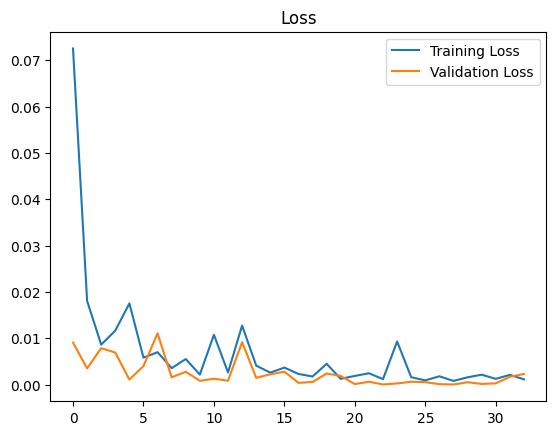

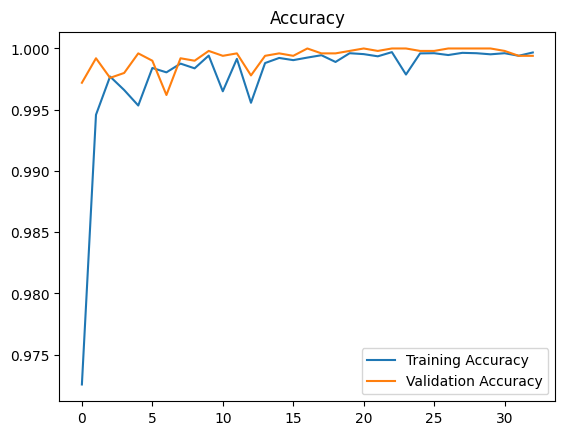

In [23]:
import matplotlib.pyplot as plt
# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

Save model

In [24]:
model.save("/kaggle/working/Upscayled_Detect_withDA_V4.h5")

Upload test set and load 

In [57]:
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

Test_dir = "/kaggle/input/mnist-upscayled/testSet"
image_size = (28, 28) 
batch_size = 100 

Testgen = ImageDataGenerator( 
    rescale=1.0 / 255,  
    rotation_range= 120,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    #brightness_range=[0.5,1.0]
    
)


Test_generator = Testgen.flow_from_directory(
    Test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)


print("Class label mapping：", Test_generator.class_indices)


Found 55999 images belonging to 2 classes.
Class label mapping： {'MINSTOrigin': 0, 'MNISTModified': 1}


In [26]:
Testgen2 = ImageDataGenerator(
    rescale=1.0 / 255         
)

Test_generator2 = Testgen2.flow_from_directory(
    Test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

Found 55999 images belonging to 2 classes.


Evaluate Model by test set, Test for Data augmentation and Not 

In [63]:
test_loss, test_accuracy = model.evaluate(Test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

560/560 ━━━━━━━━━━━━━━━━━━━━ 74s 133ms/step - accuracy: 0.9944 - loss: 0.0294
Test Loss: 0.08460584282875061
Test Accuracy: 0.9830175638198853


In [28]:
test2_loss, test2_accuracy = model.evaluate(Test_generator2)
print(f"Test Loss: {test2_loss}")
print(f"Test Accuracy: {test2_accuracy}")

560/560 ━━━━━━━━━━━━━━━━━━━━ 45s 81ms/step - accuracy: 1.0000 - loss: 6.5654e-07
Test Loss: 4.2989340727217495e-05
Test Accuracy: 0.9999821186065674


kernal shutdown reloaded

In [ ]:
"""
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

model = load_model('/kaggle/working/final_model.h5')"""

find incorrect cases

In [58]:

predictions = model.predict(Test_generator)


predicted_classes = np.round(predictions).astype(int).flatten()

true_classes = Test_generator.classes

errors = np.where(predicted_classes != true_classes)[0]
print(f"Number of misclassified images: {len(errors)}")

for i in errors[:10]:
    print(f"Misclassified image: {Test_generator.filenames[i]}")

560/560 ━━━━━━━━━━━━━━━━━━━━ 74s 132ms/step
Number of misclassified images: 911
Misclassified image: MINSTOrigin/img_16149.png
Misclassified image: MINSTOrigin/img_26348.png
Misclassified image: MINSTOrigin/img_26542.png
Misclassified image: MINSTOrigin/img_26552.png
Misclassified image: MINSTOrigin/img_27779.png
Misclassified image: MINSTOrigin/img_364.png
Misclassified image: MINSTOrigin/img_618.png
Misclassified image: MINSTOrigin/img_8926.png
Misclassified image: MNISTModified/AI_img_10049.png
Misclassified image: MNISTModified/AI_img_10052.png


In [64]:
predictions2 = model.predict(Test_generator2)


predicted2_classes = np.round(predictions2).astype(int).flatten()

true2_classes = Test_generator2.classes

errors2 = np.where(predicted2_classes != true2_classes)[0]
print(f"Number of misclassified images: {len(errors2)}")

for i in errors2[11:20]:
    print(f"Misclassified image: {Test_generator2.filenames[i]}")

560/560 ━━━━━━━━━━━━━━━━━━━━ 91s 163ms/step
Number of misclassified images: 1


print incorrect image

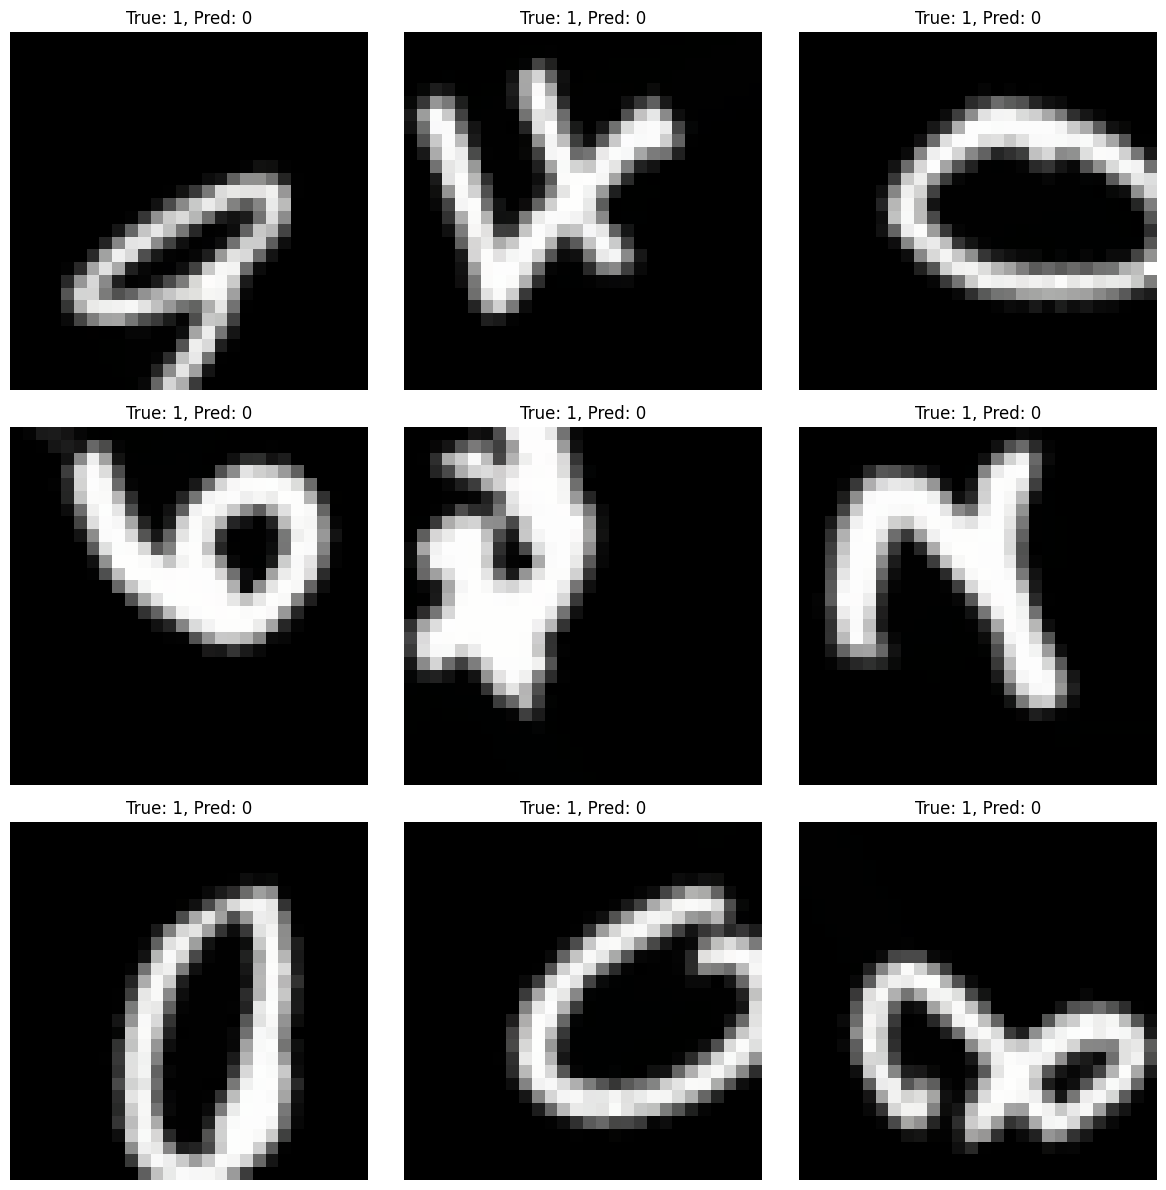

In [70]:
import matplotlib.pyplot as plt

pageN = 10

plt.figure(figsize=(12, 12))
for i, error_idx in enumerate(errors[9*pageN:9*(pageN+1)]): 
    plt.subplot(3, 3, i+1) 
    image = Test_generator[error_idx // Test_generator.batch_size][0][error_idx % Test_generator.batch_size]  
    plt.imshow(image)
    plt.title(f"True: {true_classes[error_idx]}, Pred: {predicted_classes[error_idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

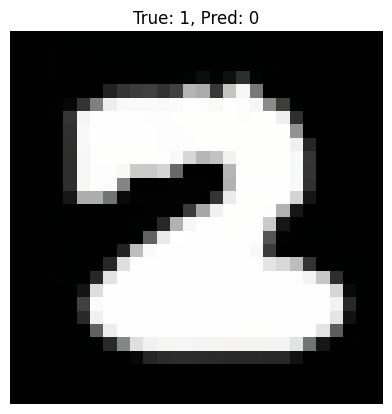

In [32]:
plt.figure(figsize=(12, 12))
for i, error_idx in enumerate(errors2[:9]): 
    plt.subplot(3, 3, i+1) 
    image = Test_generator2[error_idx // Test_generator2.batch_size][0][error_idx % Test_generator2.batch_size]  
    plt.imshow(image)
    plt.title(f"True: {true2_classes[error_idx]}, Pred: {predicted2_classes[error_idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [60]:
print(errors)
print(errors2)

[ 6834 18166 18382 18393 19755 20935 23757 26808 28057 28061 28080 28124
 28185 28195 28222 28235 28259 28290 28312 28341 28357 28394 28408 28472
 28506 28545 28574 28593 28598 28601 28620 28669 28675 28717 28723 28726
 28795 28800 28805 28824 28828 28831 28877 28888 28890 28905 28913 28920
 28947 29055 29125 29140 29163 29223 29254 29325 29356 29362 29400 29414
 29464 29567 29697 29703 29731 29767 29806 29840 29904 29926 29973 29974
 30044 30076 30085 30229 30248 30281 30284 30317 30338 30354 30372 30398
 30406 30418 30437 30458 30464 30501 30524 30529 30536 30545 30570 30581
 30634 30704 30816 30859 30935 30970 31006 31066 31077 31106 31110 31115
 31130 31253 31286 31322 31355 31356 31378 31388 31430 31435 31441 31459
 31482 31524 31530 31539 31588 31636 31683 31692 31741 31783 31871 31911
 31914 31917 31992 32013 32017 32020 32030 32040 32046 32089 32098 32129
 32146 32147 32199 32228 32236 32342 32371 32386 32441 32455 32470 32476
 32507 32576 32585 32705 32716 32747 32776 32790 32

Check misclassified cases distribution

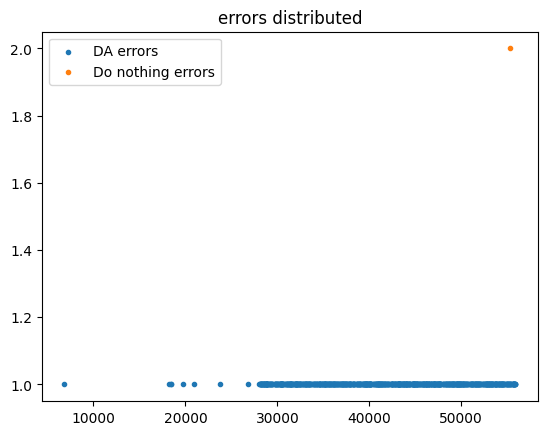

In [61]:
plt.scatter(errors, errors/errors, label='DA errors', marker=".")
plt.scatter(errors2, 2*errors2/errors2, label='Do nothing errors', marker=".")
plt.legend()
plt.title('errors distributed')
plt.show()

The final model have capabilities to find out the augmented test data and original test data with two digits error per 56000 times test.
If the augment method remove the "brightness_range", accuracy will reduce almost 1.8% (1000 cases / 56000 cases)